In [1]:
%matplotlib inline
#%qtconsole

import os
import cPickle
import numpy as np
import pandas
from scipy import linalg
import scipy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, date2num, num2date
from load_gridded_data import read_gridded_data_CMIP5_model
from gridAvg import gridAvg
import wd

In [2]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [3]:
# Load CCSM4 tas data and monthly average it using an LMR routine

data_dir = '/Users/dan/Desktop/CCSM4_ctrl/'
data_file = 'tas_sfc_Amon_CCSM4_past1000_085001-185012.nc'
data_vars = {'tas_sfc_Amon':0}

outtimeavg = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#outtimeavg = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

dd=read_gridded_data_CMIP5_model(data_dir,data_file,data_vars,outtimeavg,detrend=None)
#dd_lw = read_gridded_data_CMIP5_model(data_dir,data_file,data_vars,outtimeavg,detrend=None)


datam = np.reshape(dd['tas_sfc_Amon']['value'],[1001,-1]).transpose()
data = datam - np.tile(np.mean(datam,0),[max(datam.shape),1])
time = np.arange(850,1851)

lon_g = np.arange(0,359,1.25)
lat_g = np.arange(-90,90,0.9375)

lon_m,lat_m = np.meshgrid(lon_g,lat_g)

Reading file:  /Users/dan/Desktop/CCSM4_ctrl//tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235


/Users/dan/anaconda2/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
gridAvg.py:46: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  pmg.set_value(index,'lat_ind',lat_ind-1)
gridAvg.py:47: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  pmg.set_value(index,'lon_ind',lon_ind-1)
/Users/dan/anaconda2/envs/py27/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


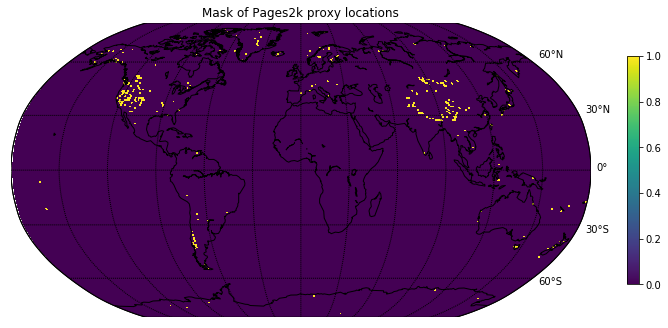

<module 'matplotlib.pyplot' from '/Users/dan/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [4]:
## Make a gridded average of normalized proxy data to use as a mask on the CCSM4 output
proxy_pandas_metafile = 'Pages2k_Metadata.df.pckl'
proxy_pandas_datafile = 'Pages2k_Proxies.df.pckl'

proxy_meta = pandas.read_pickle(proxy_pandas_metafile)
proxy_data = pandas.read_pickle(proxy_pandas_datafile)

# necessary to index this as I'd like. not sure why...
proxy_data.index=proxy_data.index.astype('float64')
proxy_data = proxy_data.astype('float64')

proxy_data = proxy_data[0:2011]

# Reformat the proxy_meta to get rid of special characters
proxy_meta.columns = [x.strip().replace(' ','_') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('(','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace(')','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('.','') for x in proxy_meta.columns]

# Change the metadata file so that indices are NCDC IDs (better matchup with data file)
proxy_meta.index = proxy_meta['PAGES_ID']
proxy_meta=proxy_meta.rename(columns = {'PAGES_ID':'NCDC_ID'})

# Replace all proxy types with a placeholder for now

proxy_meta['Archive_type'] = proxy_meta['Archive_type'].str.replace(' ','_')

# sort the metadata to have the same order as the data file
proxy_data = proxy_data.loc[:,proxy_meta.index]

# Remove one record that has a range of lat-lon values
proxy_data = proxy_data.drop('Eur_11',1)
proxy_meta = proxy_meta.drop('Eur_11',0)

proxy_data = proxy_data.dropna(1,'all')
#proxy_data = proxy_data.loc[proxy_meta.index]
proxy_meta = proxy_meta.loc[proxy_data.columns]

proxy_meta.loc[:,'Lat_N'] = proxy_meta.loc[:,'Lat_N'].astype('float64')
proxy_meta.loc[:,'Lon_E'] = proxy_meta.loc[:,'Lon_E'].astype('float64')

import gridAvg
reload( gridAvg )
from gridAvg import gridAvg
# For some reason lon goes from 0 to 359. but lat goes from -90 to 90. I'm treating it instead like it's going from -90 to 89...
xRes = 360. / len(dd['tas_sfc_Amon']['lon'])
yRes = 180. / (len(dd['tas_sfc_Amon']['lat']))

gridded, pmg, lat_g,lon_g = gridAvg(proxy_meta,proxy_data,xRes,yRes)

# Make a mask from the data
dmask = (np.nansum(gridded,0)!=0)

wd.plotMap(lon_g,lat_g,dmask,0,1,'Mask of Pages2k proxy locations')

In [5]:
# All projection into bases done upfront!
import wd; reload(wd)

tau_s = 1

boxmask = np.zeros([lla,llo], dtype=bool)
boxmask[175:185,240:260] = 1
MASK  = dmask
PRIOR = data

L  = np.product(MASK.shape)
Nlags = 1 # 1 corresponds to only diagonal values
kt = 1000/tau_s # EOF truncation for the PRIOR. kt = 1000/tau_s is no truncation
SNR = 0.5
GAMMA = 1.

sigma = wd.gt_pproxy_sigma_from_SNR(PRIOR,MASK,SNR)
# Number of times in the reconstruction
Nt    = 1

# Make pseudoproxy data and unravel into whole-domain
ypp = wd.mk_pproxies(PRIOR[:,-Nt:],MASK,sigma).ravel('C')

#####  Construct problem projected into EOF space  #####

# I'm calling the new "data" the set of kt time series (with full variance) 
# corresponding to the kt EOFs (spatial patterns). These EOFs make up the 
# "EOF space."

# Compute the EOF basis and its pinv
[u,s,v] = np.linalg.svd(PRIOR,full_matrices=False)
PRIORe = v[:kt,:].T*s[:kt]

#eB = uD[:,:kt]*np.sqrt(sD[:kt])
#eBi = (uD[:,:kt]*sD[:kt]**(-1./2.)).T
eB = u[:,:kt]
eBi = u[:,:kt].T
# H matrix for a single time projected onto EOFs
He = np.dot(np.eye(L)[np.ndarray.flatten(MASK,'C'),:],eB)

# Prior covariance in kt-rank EOF basis
Be  = wd.mkB(PRIORe,Nt,Nlags)

##### Obtain solution in EOF space #####

[xe,yest,Cxxe,Tu,Tve,nest,nestp] = wd.ls_soln(ypp,He,Be,sigma,Nt,GAMMA)

##### Rescale the problem out of EOF space #####

xest   = np.dot(eB,xe.reshape(-1,Nt,order='C'))

Cxxii = np.zeros(L*Nt)*np.nan
for ii in range(Nt):
    dblk = Cxxe[ii*kt:(ii+1)*kt,ii*kt:(ii+1)*kt]
    Cxxii[ii*L:(ii+1)*L] = np.sum(np.dot(eB,dblk)*eB,1)

Tvii = np.nan*np.zeros(L*Nt)
for ii in range(Nt):
    dblk = Tve[ii*kt:(ii+1)*kt,ii*kt:(ii+1)*kt]
    Tvii[ii*L:(ii+1)*L] = np.sum(np.dot(eB,dblk)*eB,1)

# Compute scaled residuals
yest = np.dot(np.eye(L)[np.ndarray.flatten(MASK,'C'),:],xest)

plt.hist(nestp);
print(np.std(nestp))

wd.plotMap_nl(lon_g,lat_g,MASK,'Uniform mask')
plt.set_cmap('bwr')
wd.plotMap_nl(lon_g,lat_g,x[:,-1].reshape(len(lat_g),len(lon_g)),'Reconstruction')
plt.set_cmap('bwr')
wd.plotMap_nl(lon_g,lat_g,PRIOR[:,-1].reshape(len(lat_g),len(lon_g)),'Target')
plt.set_cmap('bwr')
wd.plotMap_nl(lon_g,lat_g,x.reshape(lla,llo,order='C')-PRIOR[:,-1].reshape(lla,llo),'Posterior misfit')
plt.set_cmap('bwr')

pr = np.mean(Tvii.reshape(55296,Nt,order='C'),1)
wd.plotMap_nl(lon_g,lat_g,(pr.reshape(len(lat_g),len(lon_g))),'Pointwise resolution')

NameError: name 'lla' is not defined

In [ ]:
# Create a Gaussian blob at each lat and lon
# Interpolate to get the blob at high resolution

from scipy import interpolate

# Zero: create lat-lon grids
lon_g = np.arange(0,359,1.25)
lat_g = np.arange(-90,90,0.9375)
lon_m,lat_m = np.meshgrid(lon_g,lat_g)
las = 10
los = 10
lla = len(lat_g)
llo = len(lon_g)

# First: subselect every tenth point from the full grid.
gmask = np.zeros([lla,llo], dtype=bool)
gmask[1::las,1::los] = 1

lon_sub = lon_m[gmask]
lat_sub = lat_m[gmask]

# Pick one of these as the point of interest. Later: might make the POIs dense

poii = 140

# Now: compute distances from the point of interest (POI)

s = 1000

#dist   = 0.*np.arange(len(lon_m))
#gaumat = 0.*np.arange(len(lon_m))
gaumat = np.zeros([lla,llo])
distmat = np.zeros([lla,llo])

for ii in np.arange(lla):
    for jj in np.arange(llo):
        dist = haversine(lon_sub[poii],lat_sub[poii],lon_g[jj],lat_g[ii])
        gaumat[ii,jj] = np.exp(-dist**2./(2.*s**2.))
#        distmat[ii,jj] = dist

res = np.linalg.multi_dot([eB,Tve,eB.T,gaumat.ravel('C').T]).reshape(len(lat_g),len(lon_g))

plt.matshow(np.flipud(gaumat)),plt.colorbar()
plt.matshow(np.flipud(res)),plt.colorbar()


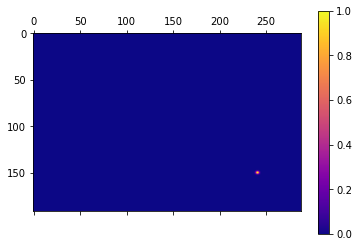

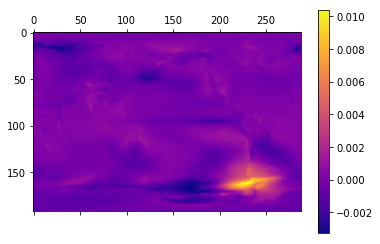

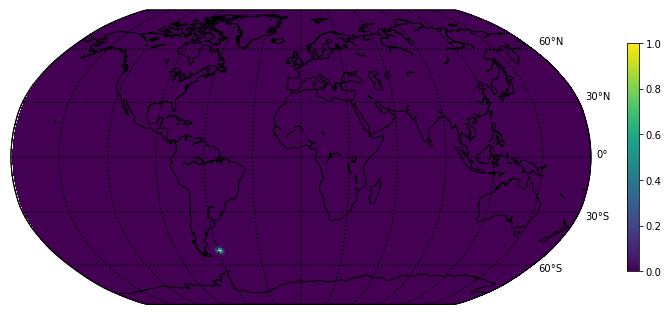

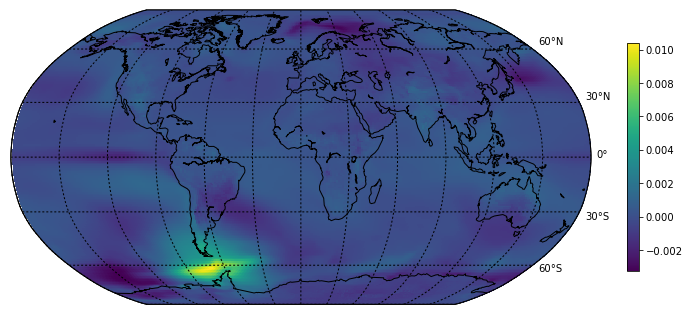

<module 'matplotlib.pyplot' from '/Users/dan/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [235]:
# Create a Gaussian blob at each lat and lon
# Interpolate to get the blob at high resolution

from scipy import interpolate

# Zero: create lat-lon grids
lon_g = np.arange(0,359,1.25)
lat_g = np.arange(-90,90,0.9375)
lon_m,lat_m = np.meshgrid(lon_g,lat_g)
las = 10
los = 10
lla = len(lat_g)
llo = len(lon_g)

# First: subselect every tenth point from the full grid.
gmask = np.zeros([lla,llo], dtype=bool)
gmask[1::las,1::los] = 1

lon_sub = lon_m[gmask]
lat_sub = lat_m[gmask]

# Pick one of these as the point of interest. Later: might make the POIs dense

poii = 140

# Now: compute distances from the point of interest (POI)

s = 100

#dist   = 0.*np.arange(len(lon_m))
#gaumat = 0.*np.arange(len(lon_m))
gaumat = np.zeros([lla,llo])
distmat = np.zeros([lla,llo])

for ii in np.arange(lla):
    for jj in np.arange(llo):
        dist = haversine(lon_sub[poii],lat_sub[poii],lon_g[jj],lat_g[ii])
        gaumat[ii,jj] = np.exp(-dist**2./(2.*s**2.))
#        distmat[ii,jj] = dist

res = np.linalg.multi_dot([eB,Tve,eB.T,gaumat.ravel('C').T]).reshape(len(lat_g),len(lon_g))

plt.matshow(np.flipud(gaumat)),plt.colorbar()
plt.matshow(np.flipud(res)),plt.colorbar()


wd.plotMap_nl(lon_g,lat_g,(gaumat),'')
wd.plotMap_nl(lon_g,lat_g,(res),'')

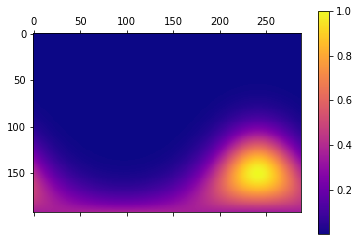

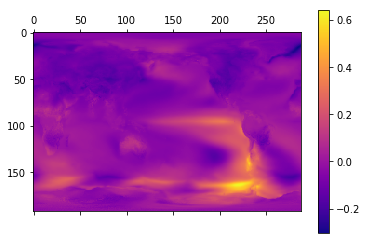

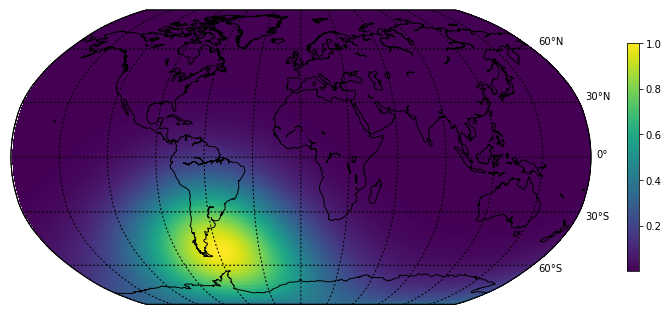

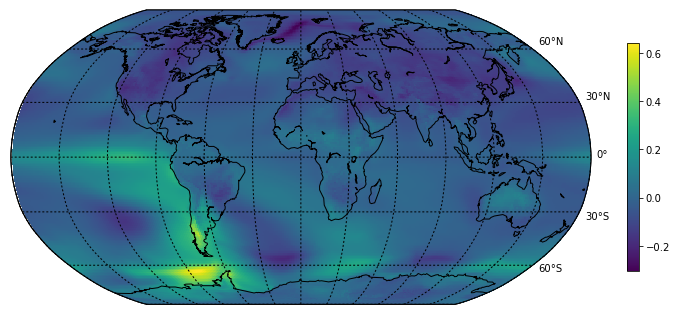

<module 'matplotlib.pyplot' from '/Users/dan/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [234]:
# Create a Gaussian blob at each lat and lon
# Interpolate to get the blob at high resolution

from scipy import interpolate

# Zero: create lat-lon grids
lon_g = np.arange(0,359,1.25)
lat_g = np.arange(-90,90,0.9375)
lon_m,lat_m = np.meshgrid(lon_g,lat_g)
las = 10
los = 10
lla = len(lat_g)
llo = len(lon_g)

# First: subselect every tenth point from the full grid.
gmask = np.zeros([lla,llo], dtype=bool)
gmask[1::las,1::los] = 1

lon_sub = lon_m[gmask]
lat_sub = lat_m[gmask]

# Pick one of these as the point of interest. Later: might make the POIs dense

poii = 140

# Now: compute distances from the point of interest (POI)

s = 3000

#dist   = 0.*np.arange(len(lon_m))
#gaumat = 0.*np.arange(len(lon_m))
gaumat = np.zeros([lla,llo])
distmat = np.zeros([lla,llo])

for ii in np.arange(lla):
    for jj in np.arange(llo):
        dist = haversine(lon_sub[poii],lat_sub[poii],lon_g[jj],lat_g[ii])
        gaumat[ii,jj] = np.exp(-dist**2./(2.*s**2.))
#        distmat[ii,jj] = dist


res = np.linalg.multi_dot([eB,Tve,eB.T,gaumat.ravel('C').T]).reshape(len(lat_g),len(lon_g))


plt.matshow(np.flipud(gaumat)),plt.colorbar()
plt.matshow(np.flipud(res)),plt.colorbar()

wd.plotMap_nl(lon_g,lat_g,(gaumat),'')
wd.plotMap_nl(lon_g,lat_g,(res),'')

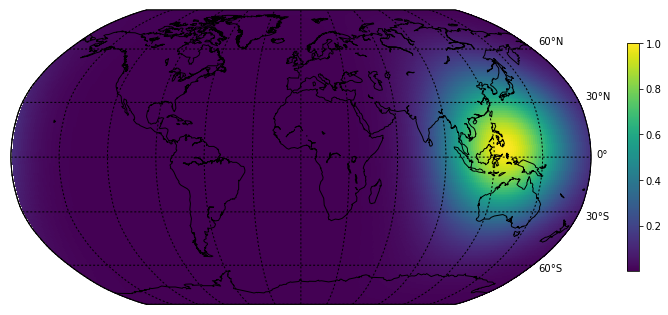

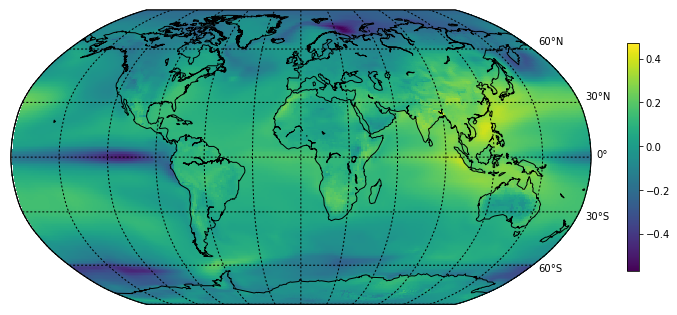

In [233]:
# Create a Gaussian blob at each lat and lon
# Interpolate to get the blob at high resolution

from scipy import interpolate

# Zero: create lat-lon grids
lon_g = np.arange(0,359,1.25)
lat_g = np.arange(-90,90,0.9375)
lon_m,lat_m = np.meshgrid(lon_g,lat_g)
las = 10
los = 10
lla = len(lat_g)
llo = len(lon_g)

# First: subselect every tenth point from the full grid.
gmask = np.zeros([lla,llo], dtype=bool)
gmask[1::las,1::los] = 1

lon_sub = lon_m[gmask]
lat_sub = lat_m[gmask]

# Pick one of these as the point of interest. Later: might make the POIs dense

poii = 300

# Now: compute distances from the point of interest (POI)

s = 3000

#dist   = 0.*np.arange(len(lon_m))
#gaumat = 0.*np.arange(len(lon_m))
gaumat = np.zeros([lla,llo])
distmat = np.zeros([lla,llo])

for ii in np.arange(lla):
    for jj in np.arange(llo):
        dist = haversine(lon_sub[poii],lat_sub[poii],lon_g[jj],lat_g[ii])
        gaumat[ii,jj] = np.exp(-dist**2./(2.*s**2.))
#        distmat[ii,jj] = dist


res = np.linalg.multi_dot([eB,Tve,eB.T,gaumat.ravel('C').T]).reshape(len(lat_g),len(lon_g))


wd.plotMap_nl(lon_g,lat_g,(gaumat),'')
wd.plotMap_nl(lon_g,lat_g,(res),'')
plt.savefig('test.png',transparent=True)
plt.show()

In [25]:
# Create a Gaussian blob at each lat and lon
# Interpolate to get the blob at high resolution

from scipy import interpolate

# Zero: create lat-lon grids
lon_g = np.arange(0,359,1.25)
lat_g = np.arange(-90,90,0.9375)
lon_m,lat_m = np.meshgrid(lon_g,lat_g)
las = 30
los = 30
lla = len(lat_g)
llo = len(lon_g)

# First: subselect every tenth point from the full grid.
gmask = np.zeros([lla,llo], dtype=bool)
gmask[1::las,1::los] = 1

lon_sub = lon_m[gmask]
lat_sub = lat_m[gmask]

# Pick one of these as the point of interest. Later: might make the POIs dense
#poii = 140

# Now: compute distances from the point of interest (POI)

s = 1000

#dist   = 0.*np.arange(len(lon_m))
#gaumat = 0.*np.arange(len(lon_m))
gaumat = np.zeros([lla,llo])
distmat = np.zeros([lla,llo])
resmat = np.zeros(lla*llo)

#for hh in np.arange(lla*llo):
for hh in np.arange(len(lon_sub)):
    for ii in np.arange(lla):
        for jj in np.arange(llo):
            dist = haversine(lon_sub[hh],lat_sub[hh],lon_g[jj],lat_g[ii])
            gaumat[ii,jj] = np.exp(-dist**2./(2.*s**2.))

    resmat[hh] = np.linalg.multi_dot([eB[hh,:],Tve,eB.T,gaumat.ravel('C').T])
    print(hh)

# I just need to compute the Gaussian at every latitude because the Earth is spherically symmetric.
# Then if I'm only interested in the diagonal values, I can just "convolve" the RHS of Tv by the Gaussians I create and get a new, smoothed version of eB, call it eBs. Then I can pump this through the rest of the matrix to get the diagonal terms. Neat!

# approach: Compute Gaussians centered on 180 latitude. There will be 192 of them.
# Cycle through longitudes and multiply the EOFs by the Gaussians.

#res = np.linalg.multi_dot([eB[poii,:],Tve,eB.T,gaumat.ravel('C').T]).reshape(len(lat_g),len(lon_g))




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


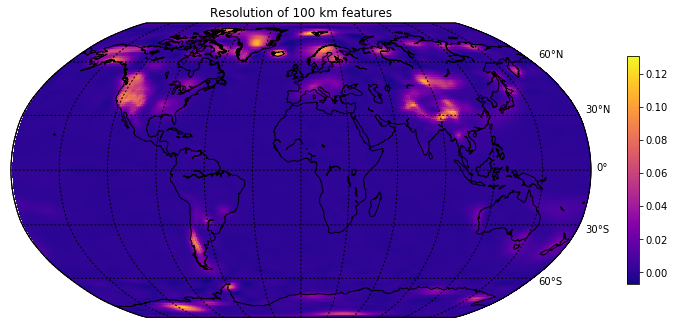

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


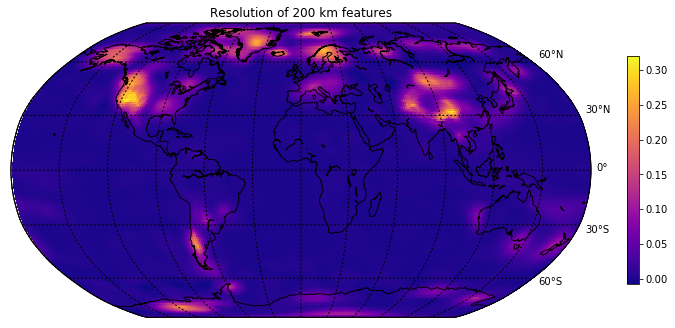

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


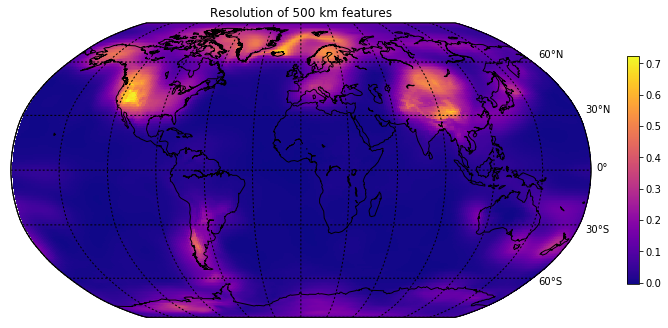

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


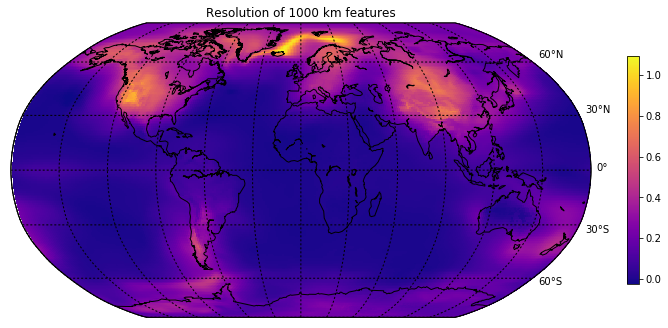

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


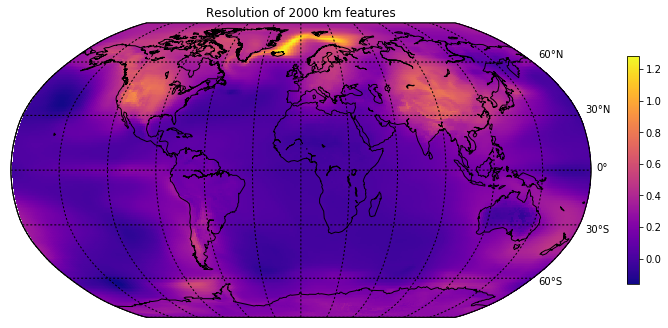

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


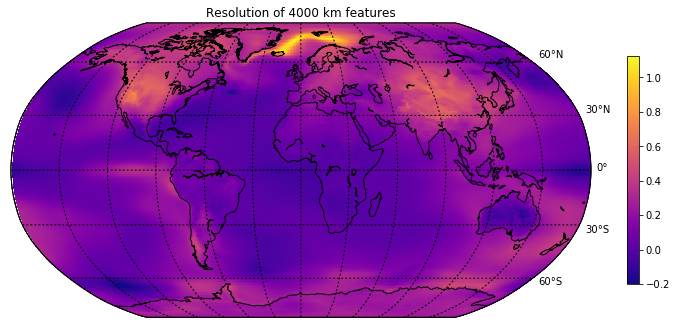

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


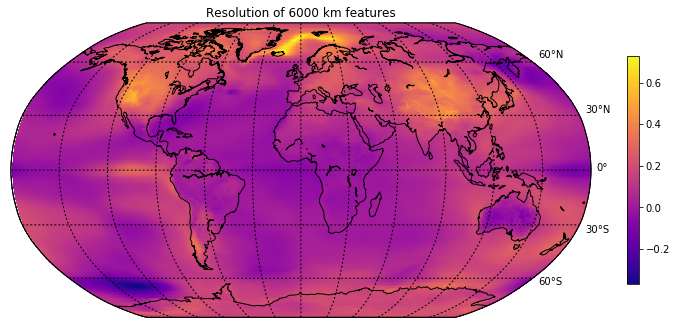

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


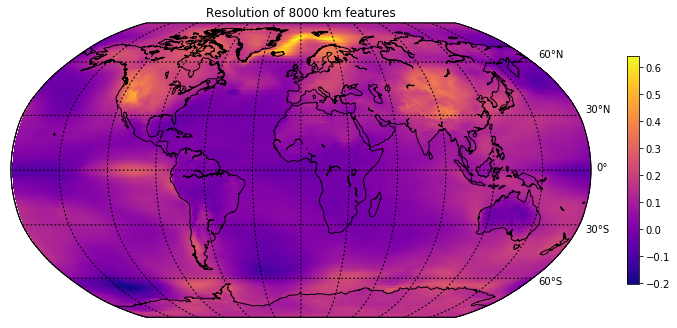

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


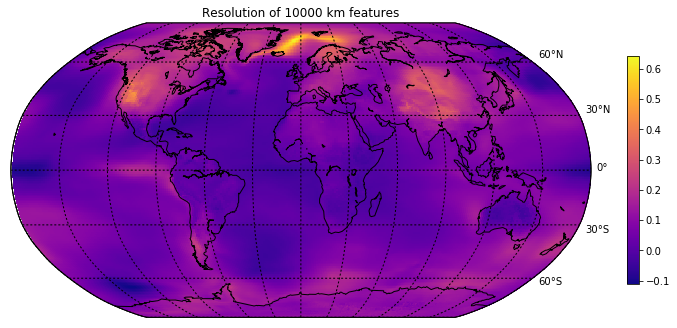

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


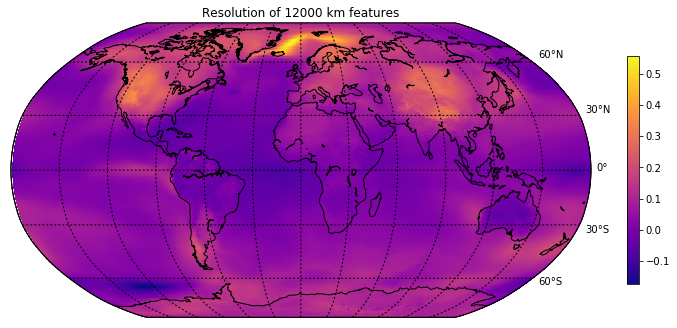

In [48]:
# Latest attempt: don't compute the full Gaussian, just some regions to sum
# parallelized

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

# Zero: create lat-lon grids
lon_g = np.arange(0,359,1.25)
lat_g = np.arange(-90,90,0.9375)
lon_m,lat_m = np.meshgrid(lon_g,lat_g)
las = 30
los = 30
lla = len(lat_g)
llo = len(lon_g)

def processInput(ii):
    loni = ii % llo
    lati = (ii-loni)/llo
    ft1 = np.concatenate([mat1[lati,:,-loni:],mat1[lati,:,:-loni]],1).ravel()
    ftp8 = np.concatenate([matp8[lati,:,-loni:],matp8[lati,:,:-loni]],1).ravel()
    ftp49 = np.concatenate([matp49[lati,:,-loni:],matp49[lati,:,:-loni]],1).ravel()
    ftp25 = np.concatenate([matp25[lati,:,-loni:],matp25[lati,:,:-loni]],1).ravel()
    if ii%4000==0:
        print(ii)
    return np.sum(eB[ft1,:],0)+0.8*np.sum(eB[ftp8,:],0)+0.49*np.sum(eB[ftp49,:],0)+0.25*np.sum(eB[ftp25,:],0)

# First: subselect every tenth point from the full grid.
gmask = np.zeros([lla,llo], dtype=bool)
gmask[1::las,1::los] = 1

lon_sub = lon_m[gmask]
lat_sub = lat_m[gmask]

# Pick one of these as the point of interest. Later: might make the POIs dense
#poii = 140

# Now: compute distances from the point of interest (POI)

svec = np.array([100, 200, 500, 1000, 2000, 4000, 6000, 8000, 10000, 12000])

for ss in np.arange(len(svec)):
    s = svec[ss]

    mat1 = np.zeros([lla,lla,llo],dtype=bool)
    matp8 = np.zeros([lla,lla,llo],dtype=bool)
    matp49 = np.zeros([lla,lla,llo],dtype=bool)
    matp25 = np.zeros([lla,lla,llo],dtype=bool)
    #gaumat = np.zeros([lla,lla*llo])
    for hh in np.arange(lla):
        #    gms = np.zeros([lla,llo])
        for ii in np.arange(lla):
            for jj in np.arange(llo):
                dist = haversine(0,lat_g[hh],lon_g[jj],lat_g[ii])
                if dist<s/10.:
                    mat1[hh,ii,jj] = 1
                elif dist<s:
                    matp8[hh,ii,jj] = 1
                elif dist<2*s:
                    matp49[hh,ii,jj] = 1
                elif dist<3*s:
                    matp25[hh,ii,jj] = 1

    inputs =  np.arange(llo*lla)
    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
    eBx = np.asarray(results)

    Tviis = np.nan*np.zeros(L*Nt)
    for ii in range(Nt):
        dblk = Tve[ii*kt:(ii+1)*kt,ii*kt:(ii+1)*kt]
        Tviis[ii*L:(ii+1)*L] = np.sum(np.dot(eB,dblk)*eBx,1)

    ress = np.mean(Tviis.reshape(55296,Nt,order='C'),1)
    wd.plotMap_nl(lon_g,lat_g,(ress.reshape(len(lat_g),len(lon_g))),'Resolution of ' + str(s) + ' km features')
    np.save('resout/eBx_'+str(s),eBx)
    np.save('resout/Tvii_'+str(s),Tviis)


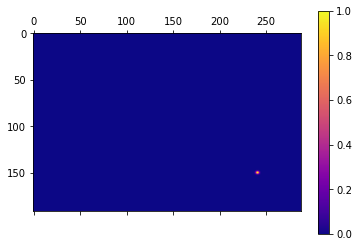

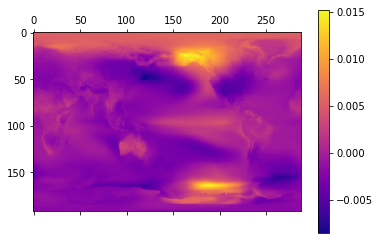

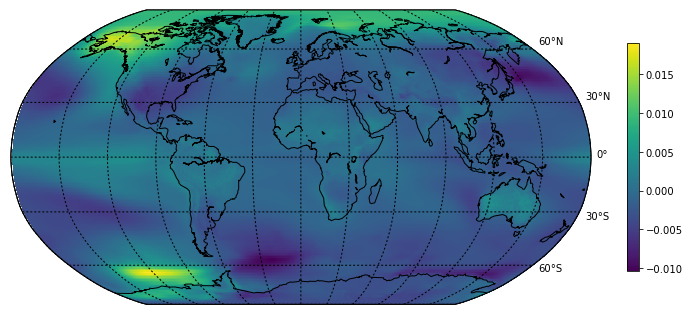

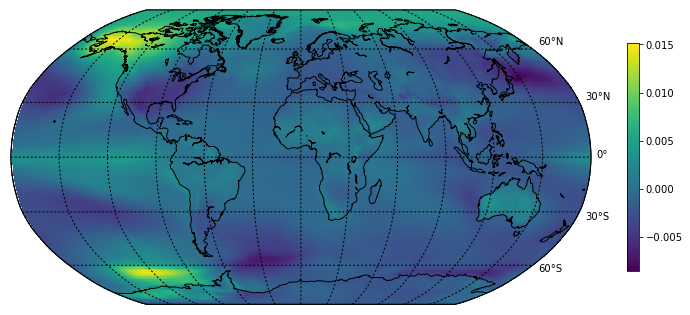

<module 'matplotlib.pyplot' from '/Users/dan/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [237]:
# Plot EOF resolution and year 1000 resolution

res = np.linalg.multi_dot([eB,Tve,eB.T,eB[:,0].ravel('C').T]).reshape(len(lat_g),len(lon_g))


wd.plotMap_nl(lon_g,lat_g,eB[:,0].reshape(len(lat_g),len(lon_g)),'')
wd.plotMap_nl(lon_g,lat_g,(res),'')

In [6]:
# Plot EOF resolution and year 1000 resolution

res = np.linalg.multi_dot([eB,Tve,eB.T,data[:,500].T]).reshape(len(lat_g),len(lon_g))

wd.plotMap_nl(lon_g,lat_g,data[:,500].reshape(len(lat_g),len(lon_g)),'')
wd.plotMap_nl(lon_g,lat_g,(res),'')

plt.savefig('test')

NameError: name 'eB' is not defined

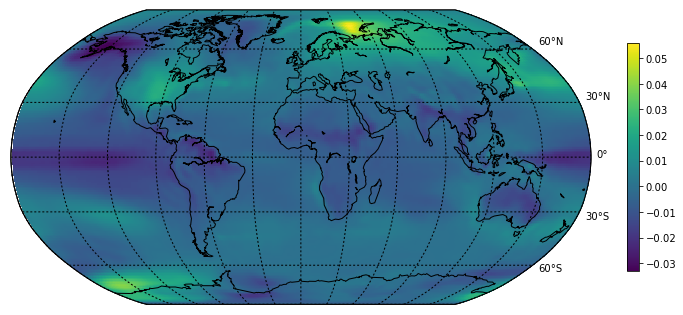

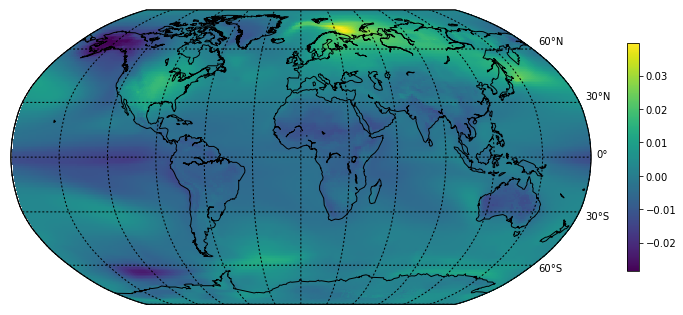

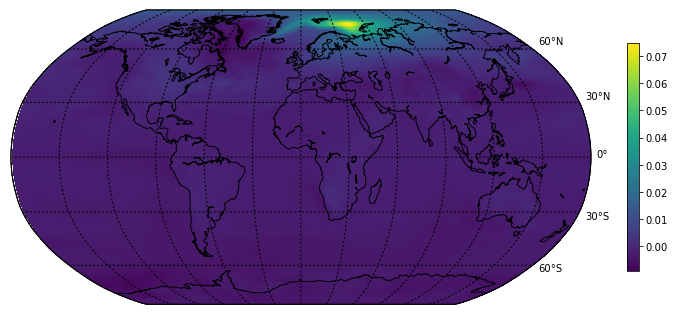

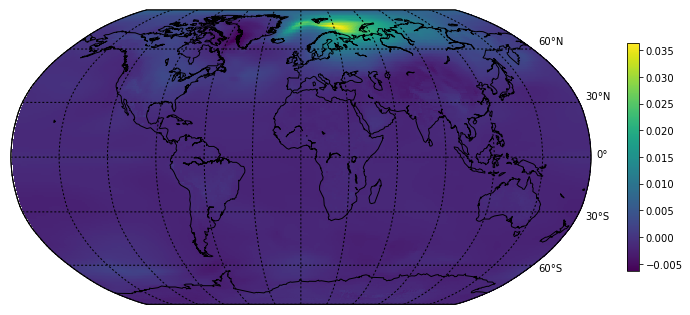

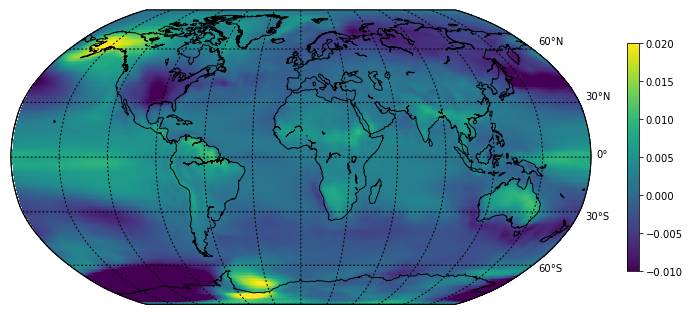

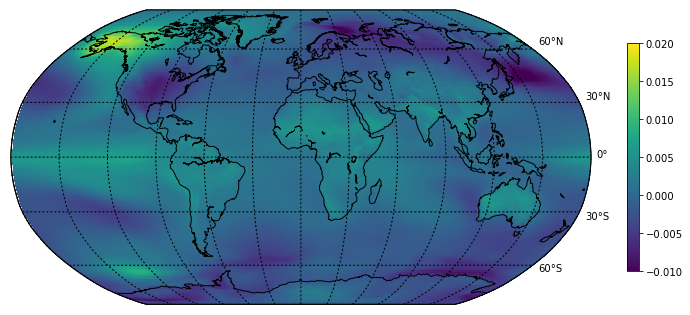

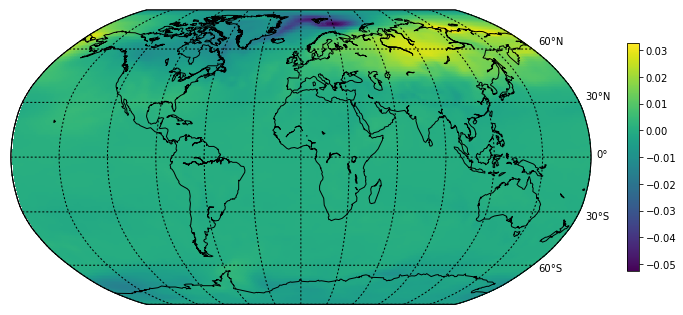

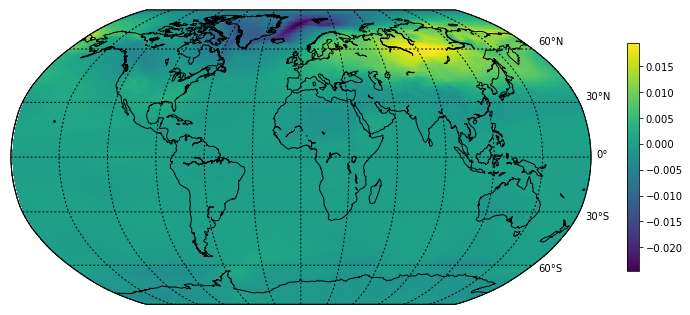

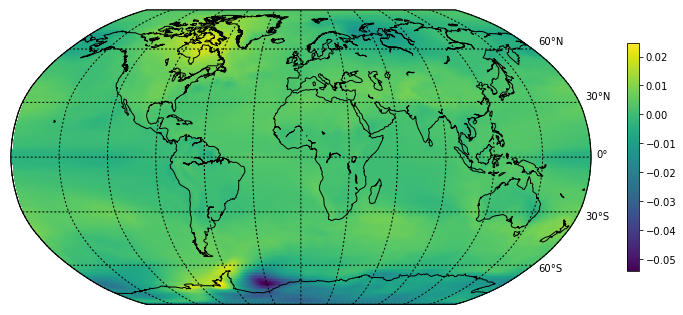

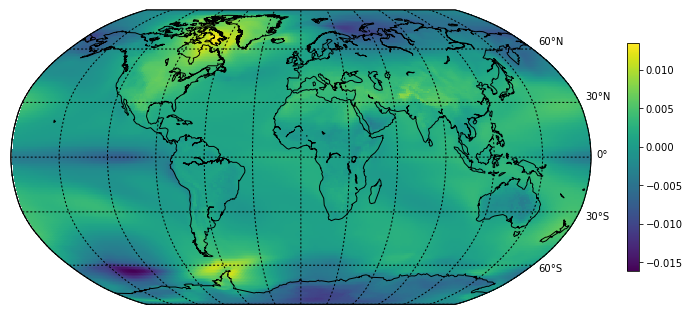

<module 'matplotlib.pyplot' from '/Users/dan/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [16]:
[um,sm,vmt] = np.linalg.svd(data_mpi,full_matrices=False)

coswts = np.cos(yy.ravel()*np.pi/180)
[uw,sw,vw] = np.linalg.svd(np.tile(coswts**.5,(1000,1)).T*data_mpi,full_matrices=False)


f = scipy.interpolate.RectBivariateSpline(y,x,(uw[:,0]*coswts**(-.5)).reshape(96,192))
umhr = f(ynew, xnew)
res = np.linalg.multi_dot([eB,Tve,eB.T,(umhr.ravel()).T]).reshape(len(lat_g),len(lon_g))
wd.plotMap_nl(lon_g,lat_g,umhr,'')
wd.plotMap_nl(lon_g,lat_g,(res),'')


f = scipy.interpolate.RectBivariateSpline(y,x,um[:,0].reshape(96,192))
umhr = f(ynew, xnew)
res = np.linalg.multi_dot([eB,Tve,eB.T,umhr.ravel().T]).reshape(len(lat_g),len(lon_g))
wd.plotMap_nl(lon_g,lat_g,umhr,'')
wd.plotMap_nl(lon_g,lat_g,(res),'')

f = scipy.interpolate.RectBivariateSpline(y,x,um[:,1].reshape(96,192))
umhr = f(ynew, xnew)
res = np.linalg.multi_dot([eB,Tve,eB.T,umhr.ravel().T]).reshape(len(lat_g),len(lon_g))
wd.plotMap(lon_g,lat_g,umhr,-0.01,0.02,'')
wd.plotMap(lon_g,lat_g,(res),-0.01,0.02,'')

f = scipy.interpolate.RectBivariateSpline(y,x,um[:,2].reshape(96,192))
umhr = f(ynew, xnew)
res = np.linalg.multi_dot([eB,Tve,eB.T,umhr.ravel().T]).reshape(len(lat_g),len(lon_g))
wd.plotMap_nl(lon_g,lat_g,umhr,'')
wd.plotMap_nl(lon_g,lat_g,(res),'')

f = scipy.interpolate.RectBivariateSpline(y,x,um[:,3].reshape(96,192))
umhr = f(ynew, xnew)
res = np.linalg.multi_dot([eB,Tve,eB.T,umhr.ravel().T]).reshape(len(lat_g),len(lon_g))
wd.plotMap_nl(lon_g,lat_g,umhr,'')
wd.plotMap_nl(lon_g,lat_g,(res),'')

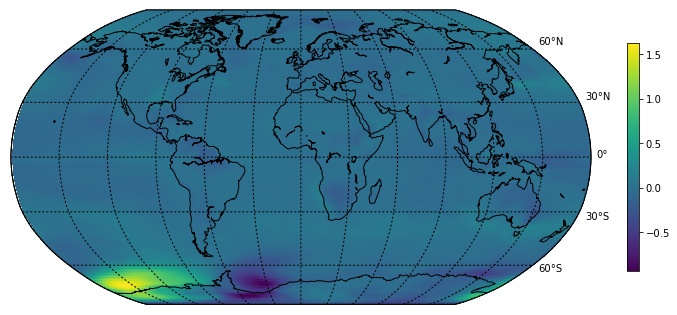

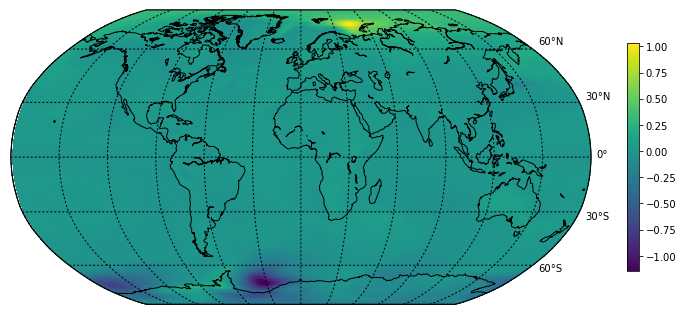

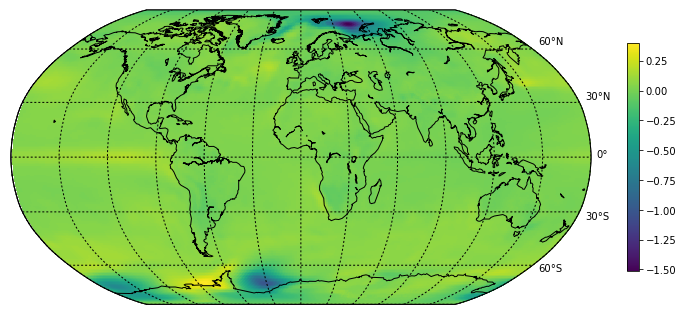

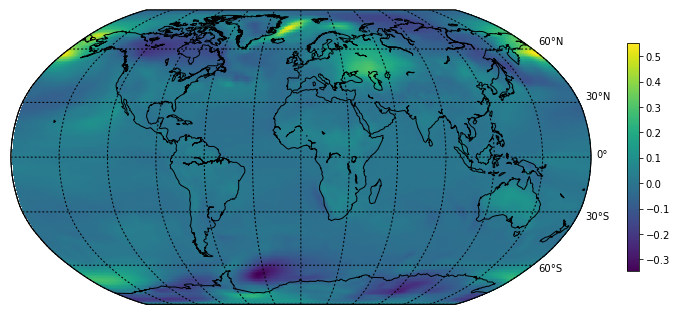

<module 'matplotlib.pyplot' from '/Users/dan/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [101]:
# Plot eigenvectors of the nullspace component

data_mpi_i = np.NaN*np.ones([55296,1000])
for ii in np.arange(1000):
    field = data_mpi[:,ii]
    f = scipy.interpolate.RectBivariateSpline(y,x,field.reshape(96,192))
    data_mpi_i[:,ii] = f(ynew, xnew).ravel()

res = np.linalg.multi_dot([eB,Tve,eB.T,data_mpi_i])

d = data_mpi_i-res
dd = (1./(1000.-1.))*(d*d).sum(-1)

[ue,se,vet] = np.linalg.svd(data_mpi_i-res,full_matrices=False)

wd.plotMap_nl(lon_g,lat_g,(dd**0.5).reshape(lla,llo),'')
wd.plotMap_nl(lon_g,lat_g,(1./(1000-1))**0.5*se[0]*ue[:,0].reshape(lla,llo),'')
wd.plotMap_nl(lon_g,lat_g,(1./(1000-1))**0.5*se[1]*ue[:,1].reshape(lla,llo),'')
wd.plotMap_nl(lon_g,lat_g,(1./(1000-1))**0.5*se[2]*ue[:,2].reshape(lla,llo),'')
wd.plotMap_nl(lon_g,lat_g,(1./(1000-1))**0.5*se[10]*ue[:,10].reshape(lla,llo),'')


